In [3]:
### Run this cell before continuing. 
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source('tests.R')
source('cleanup.R')
library(dplyr)
library(forcats)
library(mltools)
library(data.table)

Warning message in file(filename, "r", encoding = encoding):
“cannot open file 'tests.R': No such file or directory”


ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


# Predicting Diganosis of Heart Disease
## Introduction

### Background info:
Background info:Heart disease, or cardiovascular disease (CVD), is a leading global health concern, responsible for a substantial number of deaths worldwide. In 2019, approximately 17.9 million deaths were attributed to cardiovascular diseases, accounting for about 32% of total global deaths (WHO, 2021). 

Key risk factors contributing to heart disease include an unhealthy diet, physical inactivity, tobacco use, hypertension, diabetes, and genetic predisposition. Early detection and intervention are critical for effective management. Diagnosis involves medical history, physical examination, and tests.

The data provided is from different ages and sexes from Cleveland, Ohio. The dataset contains 14 variables to determine the presence of heart disease. There were 303 participants within the study and dataset. 


### Goal:
Our project aims to predict if a patient has heart disease or not. This will be represented by the “diagnosis” column, where “absence” represents < 50% diameter narrowing of major blood vessels and therefore a healthy patient, while“presence” represents > 50% diameter narrowing and therefore an unhealthy patient. We will be using the provided “Heart Disease” data set for our project. In particular, we are using the “processed Cleveland” data, as it was the most complete in comparison to other studies and contained a large sample size.

### Variables/columns of the data:

Age: Age of the patient

Sex: Male or Female

Cp: Chest pain type

Trestbps: Resting blood pressure in mmHg

Chol: Serum cholesterol in mg/dl

Fbs: Fasting blood sugar, classified as either above or below 120 mg/dl

Restecg: Resting electrocardiographic results ->either normal, having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV) or showing probable or definite left ventricular hypertrophy by Estes' criteria
Thalach: maximum heart rate achieved

Exang: Presence of exercise induced angina

Oldpeak: ST depression induced by exercise relative to rest

Slope: Slope of the peak exercise St segment

Ca: Number of major vessels coloured by fluoroscopy

Thal: Presence of Thal (a blood disorder)

diagnosis: Classifies if a heart disease is present

### Reading and Wrangling the Dataset:
The original dataset contained assigned values to represent the observations. We created both a processed and unprocessed version of the data set. The changes applied to the unprocessed dataset include; adding column titles, removing rows with missing data, and converting columns to numerical type when needed. The main distinction between the datasets is that the unprocessed leaves the numerical values so that we can apply our prediction model to all of the variables and scale each variable accordingly, while the process further mutates the data to increase interpretability when we need to represent the dataset in rather a table or visualisation.  The original dataset used numbers to represent categorical information, so in the processed data set we renamed the observations to what they represented. For both datasets we mutated the diagnosis column as the original column used to denote diagnosis contained numbers 1-4 relating to the severity of heart disease. However, the dataset was created just to detect absence vs presence of the disease, so we changed the 0 to represent absence of heart disease, and any level of severity to represent the presence of heart disease. 

In [4]:
set.seed(3456) 

## reading csv from url and renaming columns/obsevations while removing missing values
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
download.file(url, destfile = "data/processed.cleveland.data")
heart_disease_cleve <-read_csv("data/processed.cleveland.data",                                 
                                col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "diagnosis" ))|>
mutate (diagnosis = as_factor(diagnosis) |> fct_recode("absence" = "0", "presence" = "1",  "presence" = "2",  "presence" = "3",  "presence" = "4"),
        ca = as.numeric(ca),
        thal = as.numeric(thal)) |>
filter(ca != "?", thal != "?")

heart_disease_cleve_processed <- heart_disease_cleve |>
mutate (sex = as_factor(sex) |> fct_recode("male" = "1", "female" = "0"),
       cp = as_factor(cp) |>  fct_recode("typical_angina" = "1", "atypical_angina" = "2", "non_anginal_pain" = "3", "asymptomatic" = "4"),
       restecg = as_factor(restecg) |> fct_recode("normal" = "0", "stt_abnormality" = "1", "ventricular_hypertrophy" = "2"),
       exang = as_factor(exang) |> fct_recode("yes" = "1", "no" = "0"), 
       fbs = as_factor(fbs) |> fct_recode("true" = "1", "false" = "0"),
       slope = as_factor(slope) |> fct_recode("upsloping" = "1", "flat" = "2", "downsloping" = "3"),
       thal = as_factor(thal) |> fct_recode("normal" = "3", "fixed_defect" = "6", "reversable_defect" = "7"))

heart_disease_cleve_processed #figure 1.1

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `ca = as.numeric(ca)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>
63,male,typical_angina,145,233,true,ventricular_hypertrophy,150,no,2.3,downsloping,0,fixed_defect,absence
67,male,asymptomatic,160,286,false,ventricular_hypertrophy,108,yes,1.5,flat,3,normal,presence
67,male,asymptomatic,120,229,false,ventricular_hypertrophy,129,yes,2.6,flat,2,reversable_defect,presence
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
68,male,asymptomatic,144,193,true,normal,141,no,3.4,flat,2,reversable_defect,presence
57,male,asymptomatic,130,131,false,normal,115,yes,1.2,flat,1,reversable_defect,presence
57,female,atypical_angina,130,236,false,ventricular_hypertrophy,174,no,0.0,flat,1,normal,presence


### Summarized Table
We created a summarised table of the mean values of the numerical variables for both presence and absence of heart disease. If the values vary greatly between whether a patient is diagnosed or not, then it is clear that particular variable has a strong influence on a patient's diagnosis. This is also useful, as having a value that aligns closer with the mean value of presence or even surpasses the mean value of presence, would indicate a higher possible risk for heart disease.

In [5]:
summarized_table_dbl <- heart_disease_cleve |>
group_by(diagnosis) |>
summarize(trest_bps = mean(trestbps), chol = mean(chol), thalach = mean(thalach), age = mean(age), oldpeak = mean(oldpeak))
summarized_table_dbl  #figure 1.2

diagnosis,trest_bps,chol,thalach,age,oldpeak
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
absence,129.175,243.4938,158.5813,52.64375,0.598750
presence,134.635,251.8540,139.1095,56.75912,1.589051


### Histograms
Next, we created histograms to compare the distributions of a variable's influence on a diagnosis. We measured the strength of the variables influenced by how unevenly the colour (diagnosis) was displayed across the changing value of the variable; as the value of the variable changed, so did the ratio of presence. This would mean that a strongly influencing variable would have contained values where there were both a high and low ratio of heart disease, as this denote that the variable's value has a strong relationship to whether someone has heart disease. 

Warning message in geom_histogram(stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


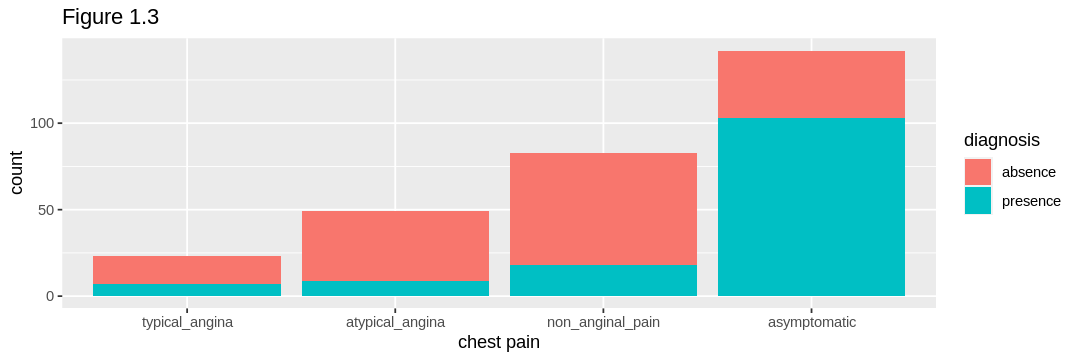

Warning message in geom_histogram(stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


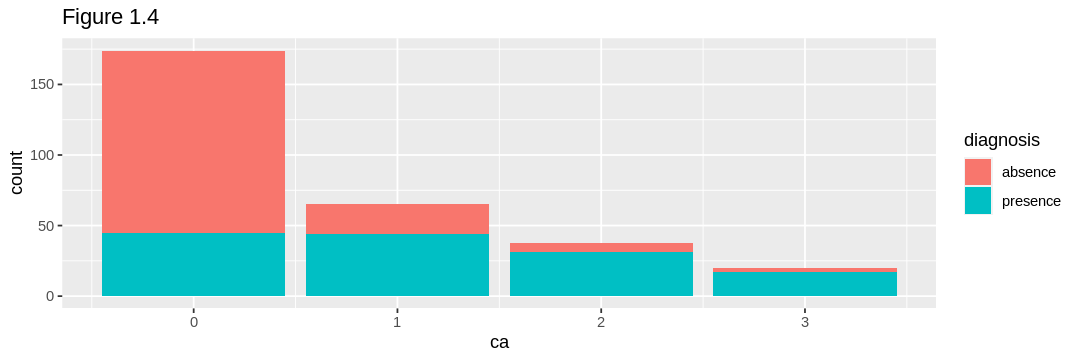

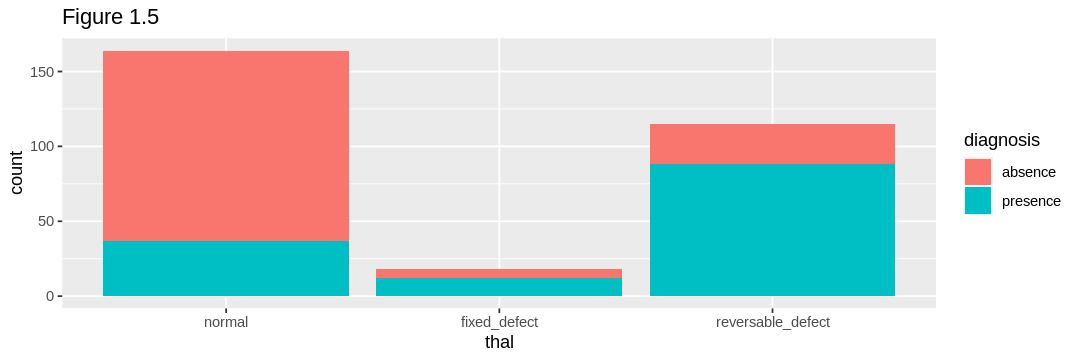

In [6]:
options(repr.plot.width = 9, repr.plot.height = 3) 

training_plot_cp <- ggplot(heart_disease_cleve_processed, aes(x = cp, fill = diagnosis)) +
geom_histogram(stat = "count") +
labs(x = "chest pain") +
ggtitle("Figure 1.3")
training_plot_cp

training_plot_ca <- ggplot(heart_disease_cleve_processed, aes(x = ca, fill = diagnosis)) +
geom_histogram(stat = "count") +
labs("number of major vessels coloured by fluorosopy") +
ggtitle("Figure 1.4")
training_plot_ca

training_plot_thal <- ggplot(heart_disease_cleve_processed, aes(x = thal, fill = diagnosis)) +
geom_histogram(stat = "count") +
ggtitle("Figure 1.5")
training_plot_thal

### Scatterplot
Next we created a plot that demonstrates the relationship between two variables and their collective influence on the presence of heart disease (as represented through color). Though using a summary table, we found two of the strongest influencing non-discrete numerical variables and used these for the plot. This results in the most readable and understandable scatter plot where the relationship between the variables is also identifiable through a range of continuous values.

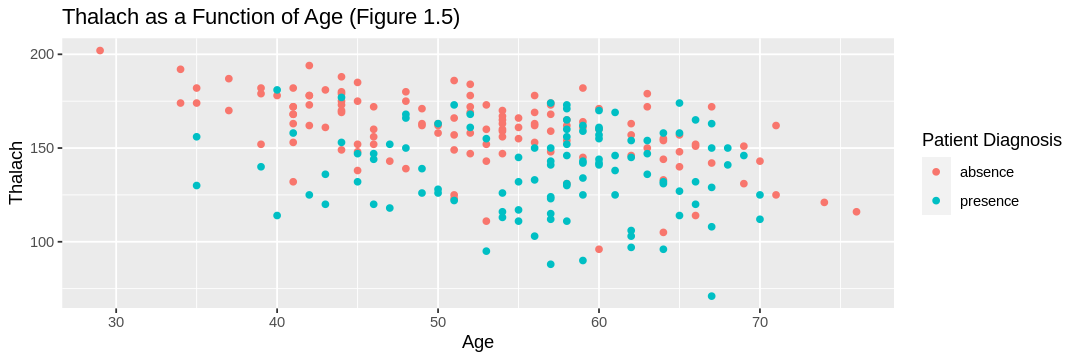

In [9]:
vis1 <- ggplot(cleve_train, aes (x = age, y = thalach, color = diagnosis)) +
geom_point() +
labs(x = "Age", y = "Thalach", color = "Patient Diagnosis") +
ggtitle("Thalach as a Function of Age (Figure 1.5)")
vis1

# Methods
### Intially Splitting the Dataset
By splitting the data into a training and testing set, we are able to train a prediction model off the larger training set, and evaluate its performance on the testing set. The testing set is a portion of the dataset that was not used to train the model and thus acts as “new” data that we can input into the model. We can then compare the model predicted diagnosis to the true value of diagnosis for the testing data to evaluate the performance and accuracy of our model. The relationship between age and thalach appears to be a weak linear relation with a negative slope.


In [10]:
set.seed(9999)
cleve_split <- initial_split(heart_disease_cleve, prop = 0.8, strata = diagnosis)  
cleve_train <- training(cleve_split)
cleve_test <- testing(cleve_split)

### Further Splitting the Dataset
We need to split the training data again, as we need to test the model on data it hasn't seen in any regard. Becuase of this, we can in no way use the initial testing split in the creation of the model. To combat this, we will split the data again.

If we use diverse divisions of the data for training and testing, we end up with multiple classifiers. When fine-tuning, we can generate numerous classifiers by employing different splits of the training data, evaluating their performance, and deriving parameter values from the combined outcomes. Depending solely on a solitary split of the overall training data might result in parameter selections that are significantly swayed by the particular validation set. Through the use of multiple train/validation divisions, our goal is to acquire a more precise assessment of accuracy. This approach ultimately aids in making a better-informed decision regarding the optimal number of neighbors (K) for the entire training dataset.

In [11]:
set.seed(9999)
cleve_split <- initial_split(cleve_train, prop = 0.75, strata = diagnosis)
cleve_subtrain <- training(cleve_split)
cleve_validation <- testing(cleve_split)

## Prediction Model
Using a classification model built on the k nearest neighbours algorithm, we were able to create a prediction model based on the values of all of the variables, as they all had a corresponding relationship with the diagnosis of heart disease. We continued to use our training data to build the model, so that we could test it on the testing data and discover the model’s accuracy on data it wasn’t built on and would perceive as new observations. Since we know the true diagnoses of the testing data, we can conclude an approximate accuracy of the model by finding the ratio to which it correctly predicts the diagnosis of this data. We used a classification model as we were solving for diagnosis, which is one of two things; present or absent, and thus this fits the use case for classification. We build this model using all variables as predictors as they all had an influence on the diagnosis of a patient as seen in the previous visualizations.



## Tuning the Classifier
### Cross Validation
By running a 10-fold cross validation, we can ensure that we are recording a more accurate representation of the models accuray, as it essentially repeats the above process 10 times, and finds the accuracy average across the 10 runs, ultimately finding a more accurate underlying accuracy of the model, as this repeated method can reduce the influence of a possible lucky or unlucky validation set on the estimate.

### Optimal Number Of Neighbors
Next we tune the classifier in an effort to improve accuracy. In this case, we will find the optimal number of neighbours to use within the algorithm. We can do this by first creating a table consisting of accuracy of predictions and the number of neighbours used. We can build this on a v-fold model to find an even more accurate representation of the optimal number of neighbors and then create a plot, where we will select the number of neighbor's that produces the greatest accuracy. 

In [27]:
set.seed(9999)
options(repr.matrix.max.rows=20)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
set_engine("kknn") |>
set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 5, to = 22, by = 1))

cleve_vfold <- vfold_cv(cleve_train, v = 10, strata = diagnosis)

knn_results <- workflow() |>
 add_recipe(cleve_recipe) |>
 add_model(knn_spec_2) |>
 tune_grid(resamples = cleve_vfold, grid = k_vals) |>
 collect_metrics() 

accuracies <- knn_results |>
 filter(.metric == "accuracy") |>
 select (-.estimator, -n, -std_err, -.config, -.metric)

accuracies_table <- accuracies
accuracies_table  #<- Figure 2.0

neighbors,mean
<dbl>,<dbl>
5,0.8354414
6,0.8354414
7,0.8144269
8,0.8144269
9,0.8272892
10,0.8272892
11,0.8310771
12,0.8310771
13,0.8308959


### Visualizing Accuracy
Next we plotted the model’s prediction accuracy against the number of neighbours used in the model. This visualisation is used to select the appropriate value of k which produces the most accurate prediction. In this model, the opitmal value of k is 17 Using this value of K creates predictions that are about 85% accurate. 


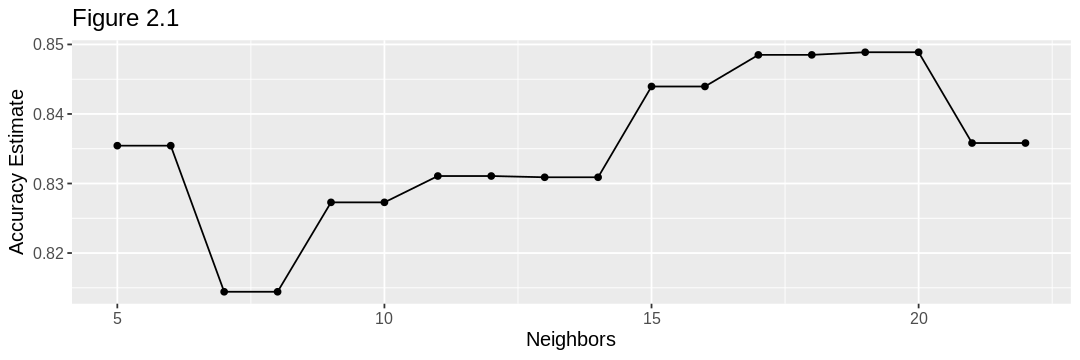

In [30]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12)) +
ggtitle("Figure 2.1")
accuracy_vs_k

### Final Model Using Ideal K Value
Next we can make a final version of the algorithm on the entire training set with the optimal number of neighbours. By testing this on the testing set, we can find the accuracy which is found to be 85%.

In [29]:
set.seed(9999)

cleve_recipe_final <- recipe(diagnosis ~ ., data = cleve_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_spec_final <- nearest_neighbor(weight_func = "rectangular", neighbors = 17) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_workflow_final <- workflow() |>
  add_recipe(cleve_recipe_final) |>
  add_model(knn_spec_final)

knn_fit_final <- knn_workflow_final |>
  fit(data = cleve_train)

test_predicted <- predict(knn_fit_final, cleve_test) |>
  bind_cols(cleve_test)

acc_final <- test_predicted |>
  metrics(truth = diagnosis, estimate = .pred_class) |>
  filter(.metric == "accuracy") |>
  select(.estimate) |>
  pull()

acc_final

[1] 0.85

## Discusstion:

### Expectation:
These results were about what we predicted as the original researchers were able to create a model of 86% accuracy (Detrano et al., 1989), so a model of 85% accuracy is not unexpected. 

### Findings and Usage:
By analysing the data, we were able to produce a classifying algorithm that is able to predict if a patient has heart disease with 85% accuracy. However, this accuracy is not sufficient for healthcare usage. It could easily result in many misdiagnoses and millions of dollars wasted on healthy individuals or sick patients not receiving the help they need. However, this prediction model could serve as a general basis for how at risk an individual is for heart disease and thus direct individuals to help they may not have known they needed. 

### Further Impact:
This model could be used to help indicate a risk for heart disease, and then used alongside a healthcare professional to diagnose a patient with heart disease. For age, age has a correlation with heart disease, so if an individual is over 56 (mean age for presence of heart disease) it is worth their while to more closely monitor their health and be aware of their greater risk for developing heart disease.

### Future Questions and Usages:
A model of this accuracy would really be most useful if available to be used at home by individuals to monitor their own health and then receive a proper diagnosis by a healthcare professional if needed. In the future, advancements in at home healthcare equipment would make a model like ours more useful and beneficial for society. However, research regarding heart disease as a whole can always be further developed such as finding additional variables that influence a diagnosis, or the degree to which heritability plays a role in a risk an individual faces in developing heart disease. Ultimately, this research and work ties into the goal of creating a healthier society with less suffering. We could also ask about the diagnosis of other diseases that could be found within the data, as possibly some individuals that displayed unhealthy characteristics were diagnosed with a separate disease, thus reducing the model's accuracy. In the future, a model that inputs more variables and is able to create a cluster algorithm may be more practicable. Expanding on the idea of other diseases, this research could also lead to further research on the overlap between diseases and the interplay between them and a patient's diagnosis. 


Citations: 
World Health Organization. (n.d.). Cardiovascular diseases (cvds). World Health 
Organization. https://www.who.int/news-room/fact-sheets/detail/cardiovascular-diseases-(cvds) 

Detrano, R., Janosi, A., Steinbrunn, W., Pfisterer, M., Schmid, J.-J., Sandhu, S., Guppy, K. H., Lee, S., & Froelicher, V. (1989). International application of a new probability algorithm for the diagnosis of coronary artery disease. The American Journal of Cardiology, 64(5), 304–310. https://doi.org/10.1016/0002-9149(89)90524-9 